# Deep Learning HW4
## Alireza Taban - 40105424

In [1]:
# Importing all necessary libraries
import cv2
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras import layers, models
import tensorflow as tf
from keras.utils import to_categorical

In [2]:
mySeed = 42
np.random.seed(mySeed)
random.seed(mySeed)
tf.random.set_seed(mySeed)

In [ ]:
!wget --no-check-certificate -O UCF50.rar https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar
!rm -rf UCF50.rar

In [ ]:
# video_path = "UCF50\\*\\*.avi"
video_path = "/content/UCF50/*/*.avi"
temp = ''
for index, video_address in enumerate(sorted(glob.glob(video_path))):
    # class_label = video_address.split('\\')[1]
    # image_name = video_address.split('\\')[-1]
    class_label = video_address.split('/')[-2]
    image_name = video_address.split('/')[-1]
    cam = cv2.VideoCapture(video_address)

    if class_label != temp:
        # path = 'data\\'+class_label
        path = '/content/data/'+class_label
        os.makedirs(path)
        video_counter = 0
        print ('Extracting ' + class_label + ' video frames...')
    temp = class_label
    # frames_path = path + '\\' + str(video_counter)
    frames_path = path + '/' + str(video_counter)
    os.makedirs(frames_path)
    frame_counter = 0
    while(frame_counter<20):

        # reading from frame
        ret,frame = cam.read()

        if ret:
            # if video is still left continue creating images
            # name = frames_path + '\\' + str(frame_counter) + '.jpg'
            name = frames_path + '/' + str(frame_counter) + '.jpg'
            # writing the extracted images
            cv2.imwrite(name, frame)
        else:
            break

        frame_counter += 1
    video_counter += 1
#     data[class_label] =

In [4]:
labels = dict()
# for index, label_address in enumerate(glob.glob("data\\*")):
for index, label_address in enumerate(sorted(glob.glob("/content/data/*"))):
    # l = label_address.split('\\')[-1]
    l = label_address.split('/')[-1]
    labels[l] = index

In [5]:
list_of_labels = []
count = 0
tmp = dict()

for i, l in enumerate(labels):
  if (count)%10 == 0 and count !=0:
    list_of_labels.append(tmp)
    tmp = dict()
  count += 1
  tmp[l] = i%10
list_of_labels.append(tmp)

In [6]:
x_train_temp = list()
y_train_temp = list()
x_test_temp = list()
y_test_temp = list()

In [7]:
labels_ = list_of_labels[2]
for label in labels_:
    # temp_path = 'data\\'+ label + '\\*'
    temp_path = '/content/data/'+ label + '/*'
    temp_list = list()
    for index, video_address in enumerate(sorted(glob.glob(temp_path))):
        # temp_list.append(video_address+'\\*.jpg')
        temp_list.append(video_address+'/*.jpg')
    random.shuffle(temp_list)
    temp_len = len(temp_list)
    threshold = int(np.floor(.75*temp_len))
    x_train_temp.extend(temp_list[:threshold])
    temp_label = np.ones(threshold)*labels_[label]
    y_train_temp.extend(list(temp_label))
    x_test_temp.extend(temp_list[threshold+1:])
    temp_label = np.ones(temp_len-threshold-1)*labels_[label]
    y_test_temp.extend(list(temp_label))

In [8]:
list_of_labels[2]

{'Lunges': 0,
 'MilitaryParade': 1,
 'Mixing': 2,
 'Nunchucks': 3,
 'PizzaTossing': 4,
 'PlayingGuitar': 5,
 'PlayingPiano': 6,
 'PlayingTabla': 7,
 'PlayingViolin': 8,
 'PoleVault': 9}

In [9]:
indices = np.arange(len(x_train_temp))
np.random.shuffle(indices)

x_train_temp = [x_train_temp[i] for i in indices]
y_train_temp = [y_train_temp[i] for i in indices]

In [10]:
x_train = list()
y_train = list()
x_test = list()
y_test = list()

In [11]:
for index, video_address in enumerate(x_train_temp):
    for image_address in sorted(glob.glob(video_address), key=lambda x: int(x.split("/")[-1].split(".")[0])):
        x_train.append(image_address)
        y_train.append(y_train_temp[index])

del x_train_temp
del y_train_temp

for index, video_address in enumerate(x_test_temp):
    for image_address in sorted(glob.glob(video_address), key=lambda x: int(x.split("/")[-1].split(".")[0])):
        x_test.append(image_address)
        y_test.append(y_test_temp[index])

del x_test_temp
del y_test_temp

In [12]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [13]:
# Convert to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)
y_train_one_hot.shape, y_test_one_hot.shape

((19760, 10), (6480, 10))

In [14]:
x_temp = []
x_test_final = []
y_test_final = []
cnt = 0

for i, x_ in enumerate(x_test):

        img = cv2.imread(x_)
        img = cv2.resize(img, (100, 100))
        img = img/255.

        if (i)%20 == 0 and i!=0:
          x_temp = np.array(x_temp)
          # print(x_temp.shape)
          x_test_final.append(x_temp)
          x_temp = []
          y_test_final.append(y_test_one_hot[i-1])

        x_temp.append(img)
        # x_batch.append(img)
        # cnt += 1
x_temp = np.array(x_temp)
x_test_final.append(x_temp)
y_test_final.append(y_test_one_hot[i-1])
        # y_batch = y[i : i + batch_size]
x_test_final = np.array(x_test_final)
y_test_final = np.array(y_test_final)
# print(x_batch.shape)
# print(y_batch.shape)


In [15]:
x_test_final.shape, y_test_final.shape

((324, 20, 100, 100, 3), (324, 10))

In [16]:
def my_generator(x, y, batch_size):

    while True:

        for i in range(0, len(x), batch_size):
            x_temp = []
            x_batch = []
            y_batch = []
            cnt = 0

            for j, x_ in enumerate(x[i : i + batch_size]):
                img = cv2.imread(x_)
                img = cv2.resize(img, (100, 100))
                img = img/255.

                if (cnt)%20 == 0 and cnt!=0:
                  x_temp = np.array(x_temp)
                  # print(x_temp.shape)
                  x_batch.append(x_temp)
                  x_temp = []
                  y_batch.append(y[i+j-1])

                x_temp.append(img)
                # x_batch.append(img)
                cnt += 1
            x_temp = np.array(x_temp)
            x_batch.append(x_temp)
            y_batch.append(y[i+j-1])
            # y_batch = y[i : i + batch_size]
            x_batch = np.array(x_batch)
            y_batch = np.array(y_batch)
            # print(x_batch.shape)
            # print(y_batch.shape)

            yield x_batch, y_batch

In [20]:
model = models.Sequential([

    layers.Conv3D(32, kernel_size=(3, 3, 3), input_shape=(20, 100, 100, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.MaxPooling3D(pool_size=(1, 2, 2)),

    layers.Conv3D(64, kernel_size=(3, 3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.MaxPooling3D(pool_size=(1, 2, 2)),

    layers.Conv3D(64, kernel_size=(3, 3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.MaxPooling3D(pool_size=(1, 2, 2)),

    layers.Conv3D(64, kernel_size=(3, 3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.MaxPooling3D(pool_size=(1, 2, 2)),

    layers.TimeDistributed(layers.Flatten()),

    layers.LSTM(16),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.45),

    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 100, 100, 32   2624      
                             )                                   
                                                                 
 batch_normalization_4 (Bat  (None, 20, 100, 100, 32   128       
 chNormalization)            )                                   
                                                                 
 activation_4 (Activation)   (None, 20, 100, 100, 32   0         
                             )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 20, 50, 50, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 20, 50, 50, 64)   

In [22]:
hist = model.fit(my_generator(x_train, y_train_one_hot, 960), steps_per_epoch=len(x_train)//960, epochs=40, validation_data=(x_test_final, y_test_final)) # 20-29

Epoch 1/40
20/20 [==============================] - 56s 2s/step - loss: 2.2946 - accuracy: 0.1292 - val_loss: 2.2877 - val_accuracy: 0.1080
Epoch 2/40
20/20 [==============================] - 42s 2s/step - loss: 2.2205 - accuracy: 0.1926 - val_loss: 2.2947 - val_accuracy: 0.1420
Epoch 3/40
20/20 [==============================] - 37s 2s/step - loss: 2.1476 - accuracy: 0.2319 - val_loss: 2.3459 - val_accuracy: 0.1142
Epoch 4/40
20/20 [==============================] - 34s 2s/step - loss: 2.0826 - accuracy: 0.2915 - val_loss: 2.3754 - val_accuracy: 0.1512
Epoch 5/40
20/20 [==============================] - 36s 2s/step - loss: 2.0003 - accuracy: 0.3309 - val_loss: 2.5101 - val_accuracy: 0.1358
Epoch 6/40
20/20 [==============================] - 35s 2s/step - loss: 1.8793 - accuracy: 0.3777 - val_loss: 2.5736 - val_accuracy: 0.1759
Epoch 7/40
20/20 [==============================] - 36s 2s/step - loss: 1.7531 - accuracy: 0.4447 - val_loss: 2.4344 - val_accuracy: 0.1667
Epoch 8/40
20/20 [==

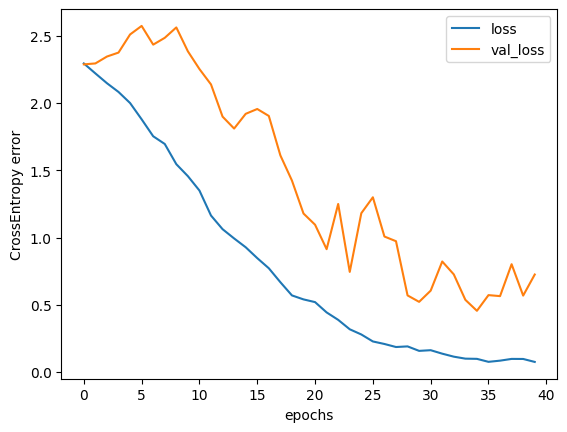

In [23]:
# Plotting the loss value during training
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("CrossEntropy error")
plt.legend()
plt.show()

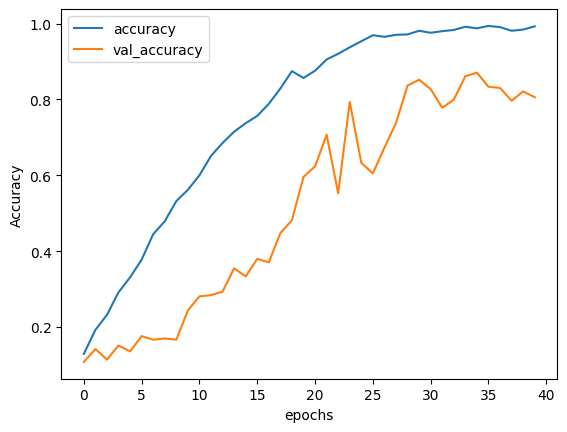

In [24]:
# Plotting the MAE value during training
plt.plot(hist.history["accuracy"], label="accuracy")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()